In [1]:
# dataPy_torch2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import cv2
import matplotlib.pyplot as plt
import multicamera_keypoints.v0.detection as mkd
import numpy as np
from o2_utils.selectors import find_files_from_pattern
from scipy.ndimage import median_filter
from skimage.transform import resize
from tqdm.notebook import tqdm
import videochef as vc

In [3]:
class FrameRetriever():
    """Implement simple caching for frame retrieval.
    Probably best to not use this with entire videos, only when you know you'll be using a small set of frames.
    """
    def __init__(self, video_file):
        self.video_file = video_file
        self.frame_dict = {}
    
    def get_frame(self, frame_number):
        if frame_number not in self.frame_dict:
            self.frame_dict[frame_number] = self.read_frame(frame_number)
        return self.frame_dict[frame_number]

    def read_frame(self, frame_number):
        with vc.io.VideoReader(self.video_file, frame_ixs=[frame_number]) as vr:
            return next(vr)


# Setup

This notebook re-implements 2d keypoint detection from CW's pipeline, but with a heuristic approach to avoid large jumps in kp position from frame to frame.
We will save two version of the data: 1) max peaks from the conf heatmap for each frame, 2) the max peaks from the conf heatmap for each frame, but with the constraint that the kp position can't move more than some decently large (ie small-error robust) distance from the previous frame.

In [6]:
bodyparts_hrnet_ordering = [
    "tail_tip",
    "tail_base",
    "spine_low",
    "spine_mid",
    "spine_high",
    "left_ear",
    "right_ear",
    "forehead",
    "nose_tip",
    "left_hind_paw_front",
    "left_hind_paw_back",
    "right_hind_paw_front",
    "right_hind_paw_back",
    "left_fore_paw",
    "right_fore_paw",
]
weights_path = "/n/groups/datta/6cam_keypoint_networks/jonah/24_07_01_219rig_v2/weights/"

use_cpu = False
conf_threshold = 0.25
max_jump_distance = 100  # pixels, for now (convert to mm later)

In [7]:
# Validate the weights paths
if isinstance(weights_path, str):
    assert os.path.isdir(weights_path), f"weights_path {weights_path} is not a directory"
elif isinstance(weights_path, dict):
    for key, val in weights_path.items():
        assert os.path.isfile(val), f"weights_path[{key}] {val} is not a file"
    assert set(weights_path.keys()) == {"bottom", "top", "side"}, f'weights_path keys {weights_path.keys()} must be "bottom", "top", and "side"'



# test 2d pred heuristics

## Prep specific video / frames / load model

In [6]:
video_dir = "/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/"
vids = find_files_from_pattern(video_dir, "*.0.mp4", n_expected=6)
vids

['/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.bottom.0.mp4',
 '/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.side1.0.mp4',
 '/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.side2.0.mp4',
 '/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.side3.0.mp4',
 '/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.side4.0.mp4',
 '/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.top.0.mp4']

In [7]:
# frame_ixs = [
#     [1044, 1045, 1046, ],
#     [2230, 2231],
# ]
frame_ixs_to_try = [  # list of lists of frames
    np.arange(1040, 1050),
    np.arange(2225, 2235),
]
vid_path = '/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.bottom.0.mp4'
frame_retriever = FrameRetriever(vid_path)
video_name, _ = os.path.splitext(vid_path)
camera = vid_path.split('.')[-3]

In [8]:
# Load the model
assert isinstance(weights_path, str)
if "bottom" in camera:
    weights_file = find_files_from_pattern(weights_path, "hrnet_bottom.pth")
elif "top" in camera:
    weights_file = find_files_from_pattern(weights_path, "hrnet_top.pth")
elif "side" in camera:
    weights_file = find_files_from_pattern(weights_path, "hrnet_side.pth")
else:
    raise ValueError(f"Unexpected camera name detected from video: {camera}")
model, nof_joints = mkd.load_model(weights_file, use_cpu=use_cpu)
if use_cpu:
    model = model.eval()
else:
    model = model.eval().to("cuda")

/n/groups/datta/Jonah/Local_code_groups/6cam_repos/o2-utils/o2_utils/selectors.py:56: UserWarning: It appears your glob pattern has no wildcard, are you sure that's right?
  warnings.warn(


In [9]:
centroids = median_filter(np.load(video_name + ".centroid.npy"), (11, 1)).astype(int)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))

In [10]:
for frameset in frame_ixs_to_try:
    for frame_ix in frameset:
        frame = frame_retriever.get_frame(frame_ix)

## Do the detections

### raw

In [66]:
for frameset in frame_ixs_to_try:
    all_uvs = np.zeros((len(frameset), nof_joints, 2), dtype=np.float32)
    all_confs = np.zeros((len(frameset), nof_joints), dtype=np.float32)
    all_y_preds = []
    all_cropped_ims = []
    for iFrame, frame_ix in enumerate(frameset):
        im = frame_retriever.get_frame(frame_ix)
        uv, conf, y_pred, cropped_im = mkd.apply_model_to_image(
            model, 
            im, 
            centroids[frame_ix], 
            clahe, 
            use_cpu=use_cpu,
            also_return_intermediates=True,    
        )
        all_uvs[iFrame, ...] = uv
        all_confs[iFrame, :] = conf
        heatmaps = y_pred.detach().cpu().numpy()
        all_y_preds.append(heatmaps)
        all_cropped_ims.append(cropped_im)
    #     if frame_ix > 1042:
    #         cropped_im = resize(cropped_im, (256, 256))
    #         for i, kp in enumerate(bodyparts_hrnet_ordering):
    #             # if conf[i] < conf_threshold:
    #                 # continue
    #             if "fore_paw" not in kp: 
    #                 continue
    #             fig, axs = plt.subplots(1, 2)
    #             hm = heatmaps[i]
    #             axs[0].imshow(cropped_im*0.5 + hm, cmap="turbo", vmin=0, vmax=1)
    #             im = axs[1].imshow(hm, cmap="turbo", vmin=0, vmax=hm.max())
    #             c = plt.colorbar(im, ax=axs[1])
    #             plt.title(f"{kp} fr {frame_ix}")

    # break

### with heuristics

In [146]:
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening

In [68]:
hm_thresh = np.exp(-4)
right_forepaw_idx = bodyparts_hrnet_ordering.index("right_fore_paw")
max_jump_distance = 25

In [69]:
def binarize_and_label_heatmap(hm, hm_thresh, selem=np.ones((3, 3))):
    binarized_hm = hm > hm_thresh
    binarized_hm = binary_opening(binarized_hm, selem=selem)
    labeled = label(binarized_hm)
    return labeled

# ii = 7
# hm = all_y_preds[ii][right_forepaw_idx]
# cropped_im = resize(all_cropped_ims[ii], (256, 256))
# labeled = binarize_and_label_heatmap(hm, hm_thresh)
# im_overlay = label2rgb(labeled, image=cropped_im, bg_label=0, alpha=0.5, bg_color=(0, 0, 0))
# fig, axs = plt.subplots(1, 2)
# axs[0].imshow(im_overlay)
# axs[1].imshow(hm, cmap="turbo", vmin=0, vmax=hm.max())


Frame 1040

Frame 1041
[1024  170]
Frame 1041, right_fore_paw dist: 2.0
[1024  170]

Frame 1042
[1024  170]
Frame 1042, right_fore_paw dist: 0.0
[1024  170]

Frame 1043
[1026  170]
Frame 1043, right_fore_paw dist: 2.0
[1026  170]

Frame 1044
[1022  174]
Frame 1044, right_fore_paw dist: 5.656854249492381
[1022  174]
[1022  174]

Frame 1045
[1036  348]
Frame 1045, right_fore_paw dist: 174.56230979223437
Frame 1045, right_fore_paw 1 (low-conf) or 0 regions detected, skipping
[1036  348]


/tmp/ipykernel_81432/1269625847.py:3: FutureWarning: `selem` is a deprecated argument name for `binary_opening`. It will be removed in version 1.0. Please use `footprint` instead.
  binarized_hm = binary_opening(binarized_hm, selem=selem)


[1036  348]

Frame 1046
[1042  338]
Frame 1046, right_fore_paw dist: 165.21501142450705
Frame 1046, right_fore_paw failed or jumped, but found regions to use.
Frame 1046, right_fore_paw closest region too far, skipping
[1042  338]
[1042  338]


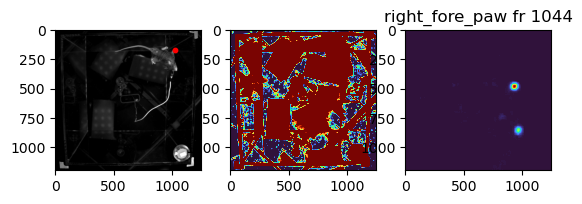

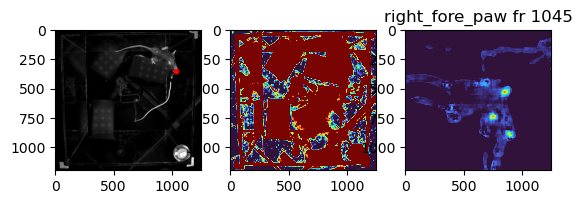

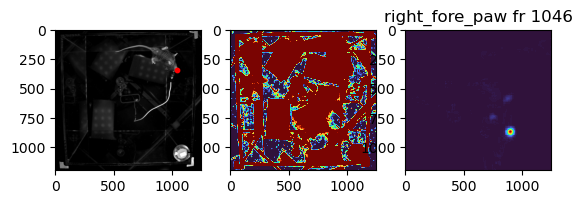

In [73]:
for frameset in frame_ixs_to_try:
    all_uvs = np.zeros((len(frameset), nof_joints, 2), dtype=np.float32)
    all_confs = np.zeros((len(frameset), nof_joints), dtype=np.float32)
    all_current_detections = np.zeros((1, nof_joints, 2), dtype=np.float32)
    bad_detection = np.array([False]*nof_joints)
    initial_frame = True
    for iFrame, frame_ix in enumerate(frameset):
        print()
        print(f"Frame {frame_ix}")
        im = frame_retriever.get_frame(frame_ix)
        uv, conf, y_pred, cropped_im = mkd.apply_model_to_image(
            model, 
            im, 
            centroids[frame_ix], 
            clahe, 
            use_cpu=use_cpu,
            also_return_intermediates=True,    
        )

        if initial_frame:
            all_current_detections[0, ...] = uv
            initial_frame = False
            all_uvs[iFrame, ...] = uv
            all_confs[iFrame, :] = conf
            continue

        # Implement heuristics.
        # 0. If no detections above default conf, skip to step 2.
        # 1. Check distance between this detection and last detection. If it's too far, skip to step 2.
        # 2. Binarize heatmap, get region centroids, and check distances to last detection. 
        #   2a. If there is only one region, and the confidence is above the default threshold, ie the net is quite confident and the keypoint really did move that far, take that as the current detection.
        #   2b. If any new regions are within the distance threshold, take the closest one as the current detection.
        
        # all_uvs[iFrame, ...] = uv
        # all_confs[iFrame, :] = conf
        uv = uv.squeeze()
        heatmaps = y_pred.detach().cpu().numpy()

        print(uv[right_forepaw_idx])
        for i, kp in enumerate(bodyparts_hrnet_ordering):
            interframe_dist = (np.linalg.norm(uv[i] - all_current_detections[0, i]))

            # just for debugging
            if kp == "right_fore_paw":
                print(f"Frame {frame_ix}, {kp} dist: {interframe_dist}")
            elif kp != "right_fore_paw": continue

            if (
                conf[i] < conf_threshold
                or interframe_dist > max_jump_distance
            ):
                bad_detection[i] = True
                labeled = binarize_and_label_heatmap(heatmaps[i], hm_thresh)
                region_props = regionprops(labeled)
                if (len(region_props) == 1) & (conf[i] > conf_threshold):
                    # assume the network was correct despite the large jump
                    print(f"Frame {frame_ix}, {kp} jumped too far but only 1 region + conf is high")
                    continue
                elif len(region_props) <= 1:
                    print(f"Frame {frame_ix}, {kp} 1 (low-conf) or 0 regions detected, skipping")
                    # assume the network has truly failed to detect the keypoint
                    continue
                else:
                    # find the closest region to the last detection
                    print(f"Frame {frame_ix}, {kp} failed or jumped, but found regions to use.")
                    pass
                region_centroids = []
                region_dists = []
                for region in region_props:
                    region_centroid = (np.array(region.centroid) * 2) - 256 + centroids[frame_ix]  # convert from 256x256 to original image space
                    region_centroids.append(region_centroid)
                    region_dists.append(np.linalg.norm(all_current_detections[0, i] - region_centroid))
                closest_region_ix = np.argmin(region_dists)
                if region_dists[closest_region_ix] < max_jump_distance:
                    print(f"Frame {frame_ix}, {kp} closest region within threshold, using")
                    uv[i] = region_centroids[closest_region_ix]
                    bad_detection[i] = False
                else:
                    print(f"Frame {frame_ix}, {kp} closest region too far, skipping")
        
        print(uv[right_forepaw_idx])
        all_uvs[iFrame, ...] = uv
        all_current_detections[0, ~bad_detection, :] = uv[~bad_detection]
        all_confs[iFrame, :] = conf
        
        # Plot for debugging
        if frame_ix > 1043:
            
            # Debug on cropped imgs
            # cropped_im = resize(cropped_im, (256, 256))
            # for i, kp in enumerate(bodyparts_hrnet_ordering):
            #     if "right_fore_paw" not in kp: 
            #         continue
            #     fig, axs = plt.subplots(1, 3)
            #     hm = heatmaps[i]
            #     axs[0].imshow(cropped_im)
            #     uv_cropped = (uv - centroids[frame_ix] + 256)/2
            #     print(uv_cropped[i])
            #     axs[0].scatter(uv_cropped[i, 0], uv_cropped[i, 1], c="r", s=10)
            #     axs[1].imshow(cropped_im*0.5 + hm, cmap="turbo", vmin=0, vmax=1)
            #     img = axs[2].imshow(hm, cmap="turbo", vmin=0, vmax=hm.max())
            #     # c = plt.colorbar(img, ax=axs[2])
            #     plt.title(f"{kp} fr {frame_ix}")

            # Debug on full imgs
            for i, kp in enumerate(bodyparts_hrnet_ordering):
                if "right_fore_paw" not in kp: 
                    continue
                fig, axs = plt.subplots(1, 3)
                hm_full = resize(heatmaps[i], (im.shape[0], im.shape[1]))
                axs[0].imshow(im)
                uv_full = uv
                print(uv_full[i])
                axs[0].scatter(uv_full[i, 0], uv_full[i, 1], c="r", s=10)
                axs[1].imshow(im[...,0]*0.5 + hm_full, cmap="turbo", vmin=0, vmax=1)
                img = axs[2].imshow(hm_full, cmap="turbo", vmin=0, vmax=hm_full.max())
                # c = plt.colorbar(img, ax=axs[2])
                plt.title(f"{kp} fr {frame_ix}")

        if frame_ix == 1046:
            break


    break

# test triangulation

In [8]:
from skimage.morphology import binary_opening
from skimage.measure import label, regionprops
from skimage.color import label2rgb

In [9]:
def binarize_and_label_heatmap(hm, hm_thresh, selem=np.ones((3, 3))):
    binarized_hm = hm > hm_thresh
    binarized_hm = binary_opening(binarized_hm, selem=selem)
    labeled = label(binarized_hm)
    return labeled


In [10]:
video_dirs = [
    "/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/"
]
frame_ixs_to_try_by_session = {
    "/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/":
    [  # list of lists of frames
        np.arange(1040, 1050),
        # np.arange(2225, 2235),
    ]
}
calibration_files_by_session = {
    "/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/":
    "/n/groups/datta/Jonah/2024_6cam_calibrations/JP_219_rig/calibration/20240529_calibration/20240529_calibration.camera_params.h5",

    
}
conf_threshold = 0.25
camera_names = ['top', 'side1', 'side2', 'side3', 'side4', 'bottom']  # this is the order from the calibration
session_dict = {}
for video_dir in video_dirs:
    vids = find_files_from_pattern(video_dir, "*.0.mp4", n_expected=6)
    session_dict[video_dir] = {}
    session_dict[video_dir]["framesets"] = frame_ixs_to_try_by_session[video_dir]
    for vid in vids:
        camera = vid.split('.')[-3]
        frame_retriever = FrameRetriever(vid)
        video_name, _ = os.path.splitext(vid)
        session_dict[video_dir][camera] = dict(frame_retriever=frame_retriever, video_name=video_name)

## First, run 2d pred and save alternate possible points

In [11]:
hm_thresh = np.exp(-4)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))

In [75]:
for session in session_dict:

    print()
    print(f"Session: {session}")
    for camera in camera_names:
        
        frame_retriever = session_dict[session][camera]["frame_retriever"]
        video_name = session_dict[session][camera]["video_name"]

        # Load the model
        assert isinstance(weights_path, str)
        if "bottom" in camera:
            weights_file = find_files_from_pattern(weights_path, "hrnet_bottom.pth")
        elif "top" in camera:
            weights_file = find_files_from_pattern(weights_path, "hrnet_top.pth")
        elif "side" in camera:
            weights_file = find_files_from_pattern(weights_path, "hrnet_side.pth")
        else:
            raise ValueError(f"Unexpected camera name detected from video: {camera}")
        model, nof_joints = mkd.load_model(weights_file, use_cpu=use_cpu)
        if use_cpu:
            model = model.eval()
        else:
            model = model.eval().to("cuda")

        # Load centroids
        centroids = median_filter(np.load(video_name + ".centroid.npy"), (11, 1)).astype(int)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))
        for frameset in session_dict[video_dir]["framesets"]:
            all_uvs = np.zeros((len(frameset), nof_joints, 2), dtype=np.float32)
            all_confs = np.zeros((len(frameset), nof_joints), dtype=np.float32)
            all_alternate_uvs = []  # will be a list of (x, y) tuples. not guaranteed to be any particular length, since have >=1 alternate uv per frame.
            all_altnernate_uvs_frame_ixs = []  # will indicate which frame each alternate uv came from, instead of doing ragged lists.
            print("Running inference with usual + alt uvs...")
            for iFrame, frame_ix in enumerate(tqdm(frameset)):

                # Run inference on the frame
                im = frame_retriever.get_frame(frame_ix)
                uv, conf, y_pred, cropped_im = mkd.apply_model_to_image(
                    model, 
                    im, 
                    centroids[frame_ix], 
                    clahe, 
                    use_cpu=use_cpu,
                    also_return_intermediates=True,    
                )
                uv = uv.squeeze()
                all_uvs[iFrame, ...] = uv
                all_confs[iFrame, :] = conf

                # Save alternate uvs
                heatmaps = y_pred.detach().cpu().numpy()
                for i, kp in enumerate(bodyparts_hrnet_ordering):

                    # Find regions of non-zero prediction by the network
                    labeled = binarize_and_label_heatmap(heatmaps[i], hm_thresh)

                    # Skip if 1 or fewer regions detected
                    if labeled.max() < 2:
                        continue

                    # Debugging plots
                    # labeled_rgb = label2rgb(labeled, image=resize(cropped_im, (256, 256)), bg_label=0, alpha=0.5, bg_color=(0, 0, 0))
                    # plt.figure()
                    # plt.imshow(labeled_rgb)
                    # plt.title(f"{kp} fr {frame_ix}")

                    # plt.figure()
                    # plt.imshow(im)
                    # plt.title(f"{kp} fr {frame_ix}")
                    # plt.scatter(uv[i, 0], uv[i, 1], c="r", s=20)

                    for region_val in range(1, labeled.max() + 1):

                        # Find the max activation within the region
                        masked = np.ma.array(heatmaps[i], mask=(labeled != region_val))
                        max_val = masked.max()
                        max_loc_cropped = np.array(np.unravel_index(np.argmax(masked), masked.shape))
                        max_loc_cropped = max_loc_cropped[::-1]  # flip to (y, x), ie uv
                        max_uv = (max_loc_cropped * 2) - 256 + centroids[frame_ix]  # convert from 256x256 to original image space

                        # Debugging plots
                        # plt.scatter(max_loc_cropped[0], max_loc_cropped[1], c="w", s=10)
                        # plt.scatter(max_uv[0], max_uv[1], c="w", s=10, marker="x")

                        # Save the alternate uv
                        all_alternate_uvs.append(max_uv)
                        all_altnernate_uvs_frame_ixs.append(frame_ix)
                    
            # Save data for this camera
            all_alternate_uvs = np.array(all_alternate_uvs)
            session_dict[session][camera][f"frameset_{frameset[0]}"] = dict(
                all_uvs=all_uvs,
                all_confs=all_confs,
                all_alternate_uvs=all_alternate_uvs,
                all_altnernate_uvs_frame_ixs=all_altnernate_uvs_frame_ixs,
            )




Session: /n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/


/n/groups/datta/Jonah/Local_code_groups/6cam_repos/o2-utils/o2_utils/selectors.py:56: UserWarning: It appears your glob pattern has no wildcard, are you sure that's right?
  warnings.warn(


Running inference with usual + alt uvs...


  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_18874/694310511.py:3: FutureWarning: `selem` is a deprecated argument name for `binary_opening`. It will be removed in version 1.0. Please use `footprint` instead.
  binarized_hm = binary_opening(binarized_hm, selem=selem)


Running inference with usual + alt uvs...


  0%|          | 0/10 [00:00<?, ?it/s]

Running inference with usual + alt uvs...


  0%|          | 0/10 [00:00<?, ?it/s]

Running inference with usual + alt uvs...


  0%|          | 0/10 [00:00<?, ?it/s]

Running inference with usual + alt uvs...


  0%|          | 0/10 [00:00<?, ?it/s]

Running inference with usual + alt uvs...


  0%|          | 0/10 [00:00<?, ?it/s]

## run triangulation w iterative refinement for any points with high reproj error

In [112]:
import multicam_calibration as mcc
import pandas as pd
from itertools import product

In [77]:
reproj_err_threshold = 20  # pixels


Session: /n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/
Camera: top
Camera: side1
Camera: side2
Camera: side3
Camera: side4
Camera: bottom


  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_18874/828947758.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


KeyboardInterrupt: 

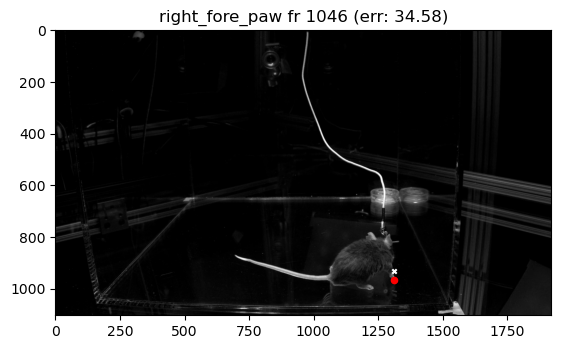

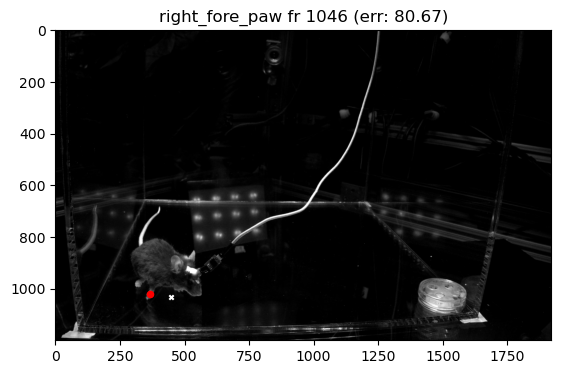

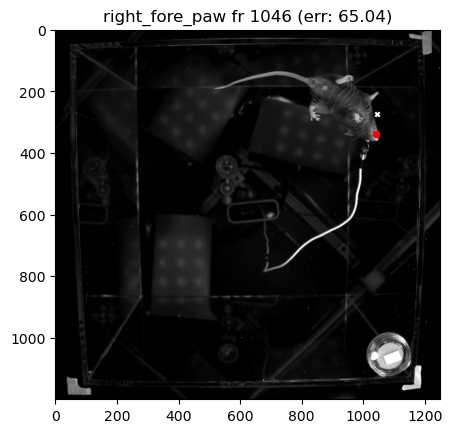

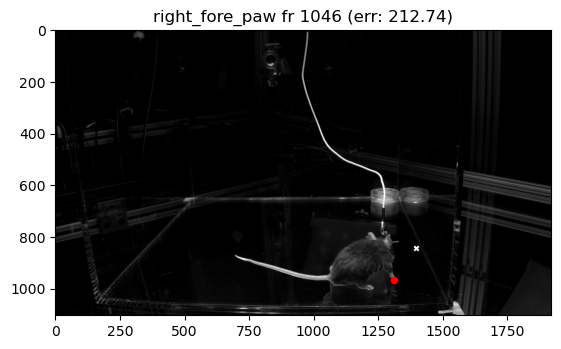

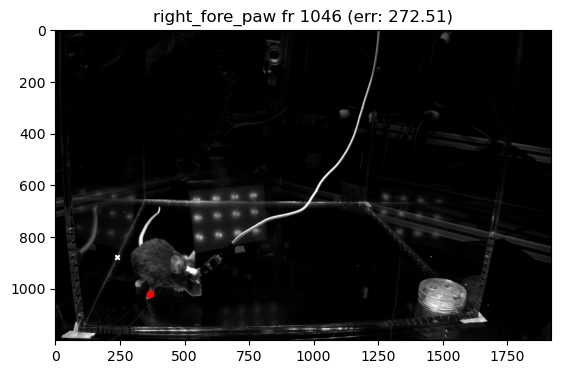

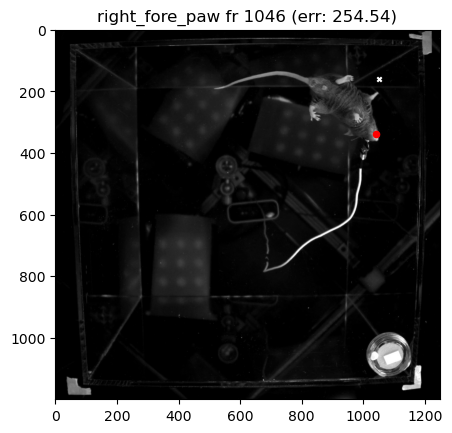

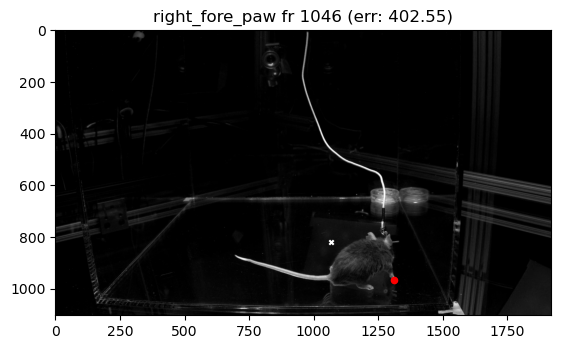

In [126]:
for session in session_dict:

    print()
    print(f"Session: {session}")

    all_extrinsics, all_intrinsics, _ = mcc.load_calibration(
        calibration_files_by_session[session], "gimbal"
    )

    alignment_file = os.path.join(session, "aligned_frame_numbers.csv")
    if not os.path.exists(alignment_file):
        print(f"Assuming all videos have the same number of frames. If this is not the case, please provide an alignment file at {alignment_file}.")
        do_alignment = False
    else:
        align_df = pd.read_csv(alignment_file)  # cols are top, bottom, side1, ..., side4, trigger_number
        max_n_frames = align_df.shape[0]
        do_alignment = True

    for frameset in session_dict[video_dir]["framesets"]:

        # Gather the data
        all_uvs = []
        all_confs = []
        all_alternate_uv_frame_ixs = []
        frameset_align_df = align_df.loc[frameset[0]:frameset[-1], :]
        max_n_frames = frameset_align_df.shape[0]
        for camera in camera_names:
            print(f"Camera: {camera}")

            # Load the data for this camera
            uvs = session_dict[session][camera][f"frameset_{frameset[0]}"]["all_uvs"]
            confs = session_dict[session][camera][f"frameset_{frameset[0]}"]["all_confs"]
            uvs[confs < conf_threshold] = np.nan  
            alt_uvs = session_dict[session][camera][f"frameset_{frameset[0]}"]["all_alternate_uvs"]
            alt_uvs_frame_ixs = session_dict[session][camera][f"frameset_{frameset[0]}"]["all_altnernate_uvs_frame_ixs"]

            # Align the frames if necessary, setting missing values to nan
            if do_alignment:
                aligned_confs = np.nan * np.zeros((max_n_frames, confs.shape[1]))
                aligned_uvs = np.nan * np.zeros((max_n_frames, uvs.shape[1], uvs.shape[2]))
                align_vec = frameset_align_df[camera].values
                aligned_confs[~pd.isnull(align_vec), ...] = confs
                aligned_uvs[~pd.isnull(align_vec), ...] = uvs
                all_uvs.append(aligned_uvs)
                all_confs.append(aligned_confs)

                local_frame_ix_to_aligned_frame_ix = {loc:aln for loc,aln in zip(frameset_align_df[camera].values, frameset_align_df.trigger_number.values) if not pd.isnull(loc)}
                aligned_alt_uvs_frame_ixs = np.array([local_frame_ix_to_aligned_frame_ix[loc] for loc in alt_uvs_frame_ixs])
                all_alternate_uv_frame_ixs.append(aligned_alt_uvs_frame_ixs)

        all_uvs = np.stack(all_uvs, axis=0)  # (nof_cameras, nof_frames, nof_joints, 2)
        all_confs = np.stack(all_confs, axis=0)  # (nof_cameras, nof_frames, nof_joints)
        
        # Run triangulation algo
        for iFrame, frame_ix in enumerate(tqdm(frameset)):

            if frame_ix < 1046:
                continue
            
            for iKeypoint, kp in enumerate(bodyparts_hrnet_ordering):
                
                if kp != "right_fore_paw":
                    continue

                # Grab the UVs for this keypoint / frame
                these_uvs = all_uvs[:, iFrame, iKeypoint, :]

                # If no cameras above conf threshold, skip
                detections_by_cam = np.any(~np.isnan(these_uvs), axis=1)
                if detections_by_cam.sum() <= 1:
                    continue

                # # Triangulate the main UVs
                pt = mcc.triangulate(these_uvs[:,None,:], all_extrinsics, all_intrinsics)  #pts is: (1, 3)

                # Reproject the triangulated points into the cameras which had good detections
                def get_mean_reproj_err(pt, these_uvs, all_extrinsics, all_intrinsics):
                    reproj_errs = []
                    for iCam, camera in enumerate(camera_names):
                        if not detections_by_cam[iCam]:
                            continue
                        extrinsics = all_extrinsics[iCam]
                        intrinsics = all_intrinsics[iCam]
                        reproj = mcc.project_points(pt, extrinsics, *intrinsics)
                        err = np.linalg.norm(reproj - these_uvs[iCam])
                        # DEBUG
                        frame_retriever = session_dict[session][camera]["frame_retriever"]
                        plt.figure()
                        plt.title(f"{kp} fr {frame_ix} (err: {err:.2f})")
                        plt.imshow(frame_retriever.get_frame(frame_ix))
                        plt.scatter(these_uvs[iCam, 0], these_uvs[iCam, 1], c="r", s=20)
                        plt.scatter(reproj[0,0], reproj[0,1], c="w", s=10, marker="x")
                        
                        reproj_errs.append(err)
                    return np.mean(reproj_errs)
                
                mean_reproj_err = get_mean_reproj_err(pt, these_uvs, all_extrinsics, all_intrinsics)
                if mean_reproj_err < reproj_err_threshold:
                    continue

                # Permute all the alt UVs from each camera with a detection in this frame, and check the reproj error.
                all_alternate_uvs_by_cam = []
                for iCam, camera in enumerate(camera_names):
                    if not detections_by_cam[iCam]:
                        all_alternate_uvs_by_cam.append(np.array([[np.nan, np.nan]]))
                        continue
                    all_alternate_uvs = session_dict[session][camera][f"frameset_{frameset[0]}"]["all_alternate_uvs"]
                    alt_uvs_this_frame = all_alternate_uvs[all_alternate_uv_frame_ixs[iCam] == frame_ix]
                    all_alternate_uvs_by_cam.append(alt_uvs_this_frame)
                alt_uv_combos = list(product(*all_alternate_uvs_by_cam))
                for alt_uv_combo in alt_uv_combos:
                    alt_uv = np.stack(alt_uv_combo, axis=0)
                    pt = mcc.triangulate(alt_uv, all_extrinsics, all_intrinsics)
                    alt_mean_reproj_err = get_mean_reproj_err(pt, these_uvs, all_extrinsics, all_intrinsics)
                    if alt_mean_reproj_err < reproj_err_threshold:
                        print(f"Triangulation for {kp} fr {frame_ix} improved from {mean_reproj_err:.2f} to {alt_mean_reproj_err:.2f}")
                        break
                break
            break
        break
    break

                # Then pair that with each alt uv from each other camera, starting again with the camera with the highest main uv conf,
                # (just do pairs of cameras for now) for triangulation,
                # and check the reproj error; if it's less than the main triangulation, use that instead.
                # [Need to decide what to do if there are, eg, 4 cameras that all disagree ]
    

In [123]:
mean_reproj_err

103.1535024260957

In [124]:
reproj_err_threshold

20